In [ ]:
print("hello worldm")

hello world


In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
image, label = dataset[0]
image.shape

torch.Size([1, 28, 28])

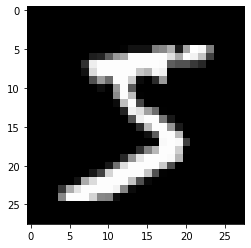

In [ ]:
plt.imshow(image.permute(1, 2, 0), cmap = 'gray')

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split( dataset, [train_size, val_size])

In [ ]:
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size = 144

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images:  torch.Size([144, 1, 28, 28])


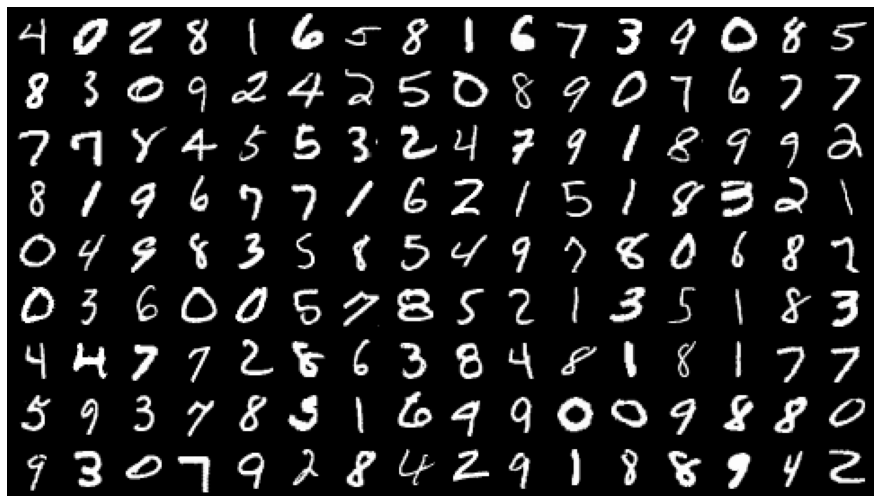

In [ ]:
for images, _ in train_loader:
  print('images: ', images.shape)
  plt.figure(figsize = (16, 9))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 16).permute((1, 2, 0)))
  break

In [ ]:
for images, labels in train_loader:
  print('images.shape:', images.shape)
  inputs = images.reshape(-1, 784)
  print('inputs.shape:', inputs.shape)
  break

images.shape: torch.Size([144, 1, 28, 28])
inputs.shape: torch.Size([144, 784])


In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32
inputs.shape[-1]

784

In [ ]:
hidden_layer = nn.Linear(input_size, hidden_size)

In [ ]:
hidden_layer_outputs = hidden_layer(inputs)
print('hidden_layer_outputs.shape: ', hidden_layer_outputs.shape)

hidden_layer_outputs.shape:  torch.Size([144, 32])


In [ ]:
hidden_layer_outputs_direct = inputs @ hidden_layer.weight.t() + hidden_layer.bias
hidden_layer_outputs_direct.shape

torch.Size([144, 32])

In [ ]:
torch.allclose(hidden_layer_outputs, hidden_layer_outputs_direct, 1e-3)

True

In [ ]:
hidden_layer_outputs

tensor([[ 0.1235, -0.2655,  0.0956,  ..., -0.0598, -0.0249, -0.0241],
        [ 0.2274, -0.1949,  0.0814,  ..., -0.1236,  0.3819, -0.2886],
        [ 0.3058, -0.2165,  0.0498,  ...,  0.4646, -0.0414, -0.1479],
        ...,
        [-0.0060, -0.3059,  0.2169,  ..., -0.0816,  0.1010, -0.1511],
        [-0.0129, -0.2036,  0.3562,  ..., -0.0083,  0.2646,  0.0510],
        [ 0.1970,  0.0433,  0.2263,  ..., -0.1187,  0.2186, -0.0955]],
       grad_fn=<AddmmBackward0>)

In [ ]:
hidden_layer_outputs_direct

tensor([[ 0.1235, -0.2655,  0.0956,  ..., -0.0598, -0.0249, -0.0241],
        [ 0.2274, -0.1949,  0.0814,  ..., -0.1236,  0.3819, -0.2886],
        [ 0.3058, -0.2165,  0.0498,  ...,  0.4646, -0.0414, -0.1479],
        ...,
        [-0.0060, -0.3059,  0.2169,  ..., -0.0816,  0.1010, -0.1511],
        [-0.0129, -0.2036,  0.3562,  ..., -0.0083,  0.2646,  0.0510],
        [ 0.1970,  0.0433,  0.2263,  ..., -0.1187,  0.2186, -0.0955]],
       grad_fn=<AddBackward0>)

In [ ]:
F.relu(torch.tensor([[1, -1, 0], [-0.1, 0.2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [ ]:
relu_outputs = F.relu(hidden_layer_outputs)
print(relu_outputs.shape)
print('min(layer1_outputs):', torch.min(hidden_layer_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

torch.Size([144, 32])
min(layer1_outputs): -0.6402501463890076
min(relu_outputs): 0.0


In [ ]:
output_size = 10
final_layer = nn.Linear(hidden_size, output_size)


In [ ]:
final_outputs = final_layer(relu_outputs)

In [ ]:
F.cross_entropy(final_outputs, labels)

tensor(2.2980, grad_fn=<NllLossBackward0>)

In [ ]:
outputs = (F.relu(inputs@hidden_layer.weight.t() + hidden_layer.bias)) @final_layer.weight.t() + final_layer.bias
torch.allclose(outputs, final_outputs, 1e-3)

True

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [ ]:
class MyMnistModel(nn.Module):
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    self.layer1 = nn.Linear(in_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.layer1(xb)
    out = F.relu(out)
    out = self.layer2(out)
    return out
  
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

    
  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss' : loss, 'val_acc': acc}
    # return {'val_loss' : loss}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
print(final_outputs.shape)
print(hidden_layer_outputs.shape)
print(inputs.shape)

torch.Size([144, 10])
torch.Size([144, 32])
torch.Size([144, 784])


In [ ]:
input_size = 784
hidden_size = 32
num_classes = 10

In [ ]:
model = MyMnistModel(input_size, hidden_size, out_size=10)

In [ ]:
for i in model.parameters():
  print(i.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss:', loss.item())
  break

print('outputs.shape', outputs.shape)
print('Sample ouputs :\n', outputs[:2].data)

RuntimeError: ignored

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([144, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([7, 9, 7, 6, 3, 5, 7, 1, 0, 2, 9, 6, 4, 0, 8, 9, 4, 3, 0, 6, 3, 1, 2, 7,
        4, 0, 4, 1, 2, 1, 5, 4, 6, 9, 2, 6, 9, 9, 9, 4, 2, 3, 4, 9, 9, 9, 9, 2,
        5, 6, 9, 0, 9, 9, 0, 1, 2, 0, 1, 0, 4, 8, 4, 1, 6, 7, 8, 0, 5, 6, 7, 4,
        1, 3, 7, 1, 8, 7, 1, 0, 7, 9, 8, 4, 1, 1, 8, 7, 1, 7, 1, 2, 2, 7, 2, 0,
        2, 3, 5, 3, 1, 0, 4, 3, 2, 4, 4, 3, 1, 4, 0, 0, 9, 5, 0, 3, 8, 0, 8, 3,
        8, 2, 6, 2, 4, 6, 6, 4, 0, 5, 8, 1, 8, 5, 6, 9, 5, 6, 9, 9, 0, 7, 6, 7,
        0, 3, 4, 6, 3, 1, 8, 7, 7, 0, 3, 9, 6, 5, 4, 8, 8, 2, 5, 2, 7, 1, 4, 1,
        1, 5, 2, 8, 2, 2, 2, 6, 4, 6, 8, 0, 6, 2, 8, 6, 9, 9, 4, 2, 7, 9, 3, 5,
        7, 9, 3, 6, 1, 2, 1, 0, 9, 3, 1, 3, 9, 1, 5, 0, 2, 1, 7, 7, 6, 1, 0, 0,
        7, 6, 9, 6, 6, 7, 9, 1, 9, 4, 4, 9, 0, 3, 1, 8, 0, 9, 8, 3, 0, 0, 3, 0,
        3, 7, 6, 8, 5, 2, 0, 7, 8, 8, 7, 8, 6, 9, 8, 0, 4, 9, 6, 2, 5, 5, 3, 1,
        5, 5, 8, 8, 3, 2, 5, 4, 4, 9, 3, 1, 8, 8, 8, 9, 7, 7, 1, 5, 0, 3, 7, 3],
       device='cu

In [ ]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
# Model (on GPU)
model = MyMnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MyMnistModel(
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[{'val_loss': 2.3053159713745117, 'val_acc': 0.11662851274013519}]

In [ ]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2691, val_acc: 0.9206
Epoch [1], val_loss: 0.2505, val_acc: 0.9233
Epoch [2], val_loss: 0.1556, val_acc: 0.9543
Epoch [3], val_loss: 0.2474, val_acc: 0.9266
Epoch [4], val_loss: 0.1785, val_acc: 0.9438
Epoch [5], val_loss: 0.1653, val_acc: 0.9488
Epoch [6], val_loss: 0.1970, val_acc: 0.9414
Epoch [7], val_loss: 0.2031, val_acc: 0.9419
Epoch [8], val_loss: 0.1233, val_acc: 0.9636
Epoch [9], val_loss: 0.1378, val_acc: 0.9574


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 0.1141, val_acc: 0.9658
Epoch [1], val_loss: 0.1161, val_acc: 0.9659
Epoch [2], val_loss: 0.1144, val_acc: 0.9666
Epoch [3], val_loss: 0.1168, val_acc: 0.9643
Epoch [4], val_loss: 0.1165, val_acc: 0.9659


Text(0, 0.5, 'Loss')

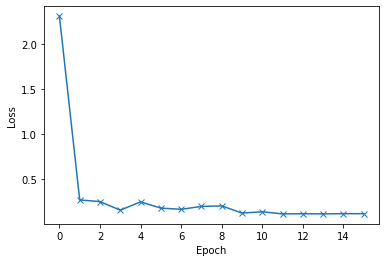

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses ,'-x')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

In [ ]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return preds[0].item()

Label: 2 , Predicted: 2


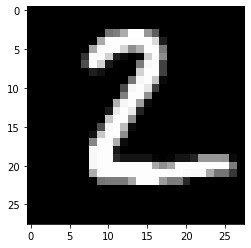

In [ ]:
img, label = test_dataset[1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


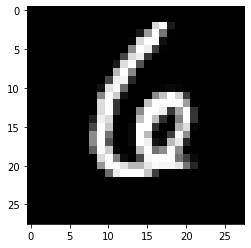

In [ ]:
img, label = test_dataset[123]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


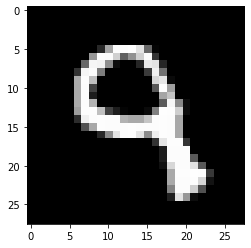

In [ ]:
img, label = test_dataset[4000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 6


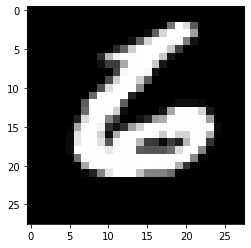

In [ ]:
img, label = test_dataset[9999]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))